<a href="https://colab.research.google.com/github/e-chong/Singapore-Ship-Detection/blob/master/Cut_Patches_and_intersect_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio
!pip install geopandas
!pip install progressbar2

In [0]:
# Load Dependencies
import numpy as np
import pandas as pd
import geopandas as gpd # vector spatial operations
from shapely.geometry import Polygon # vector geometries
import rasterio as rio # raster spatial operations
from rasterio.plot import show #convenience wrapper for pyplot.imshow for RGB and 1 band images
import os
import time
import progressbar
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Functions
credit to # https://gis.stackexchange.com/questions/299787/finding-pixel-location-in-raster-using-coordinates

In [0]:
# returns matrix of [n ships, patch_size, patch_size]
def create_ship_patches(ships, img, patch_size=30):
  coordinates = list(zip(ships.geometry.x, ships.geometry.y))
  with progressbar.ProgressBar(max_value=len(ships.index)) as bar: # creates progress bar
    patch_list = np.zeros([len(ships.index), patch_size, patch_size, len(img.indexes)])
    for i, (lon, lat) in enumerate(coordinates): # Loop through your list of coords
      py, px = img.index(lon, lat) # Get pixel coordinates from map coordinates
      window = rio.windows.Window(px - patch_size//2, py - patch_size//2, patch_size, patch_size) # Build an NxN window
      patch = img.read(window=window) # clip is a nbands * patch_size * patch_size numpy array
      patch_list[i] = np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
      bar.update(i)
  return patch_list.astype(int)

In [0]:
# creates patches for use in classifying ship or no ship
def create_patches(img, patch_size=50, step_size=30):
  n_patches = len(range(0,img.height, step_size))* len(range(0,img.width, step_size))
  patches = np.zeros([n_patches, patch_size, patch_size, len(img.indexes)])
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across imgage row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size)
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array
          patches[index] = np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
          index += 1
          bar.update(index)
  return patches.astype(int)


In [0]:
# returns boolean list of whether patches intersect with any ships
def patch_intersects_ship(ships, img, patch_size=50, step_size=30):
  n_patches = len(range(0,img.height, step_size))* len(range(0,img.width, step_size))
  isShip_list = [] #list to hold all the patch locations
  x_list = []
  y_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across imgage row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          # create polygon with patches spatial coordinates
          patch_poly = Polygon([img.transform * (window.col_off, window.row_off), #must be a more pythonic way to do this
                              img.transform * (window.col_off + window.width, window.row_off),
                              img.transform * (window.col_off + window.width, window.row_off + window.height),
                              img.transform * (window.col_off, window.row_off + window.height)])
          isShip = np.any(ships.intersects(patch_poly)) #intersect ships with polygon and chek if any are positive
          isShip_list.append(isShip) #append result to list
          x_list.append(x),
          y_list.append(y)
          index += 1
          bar.update(index)
  results = pd.DataFrame({'isShip':isShip_list, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results

# Testing

In [7]:
drive_path = '/content/drive/My Drive/MUSA-650-Final-Project/'
# NOTE: unified notebook will be able to use the title field from sceneMeta to get specific images and ship points
files = os.listdir(drive_path)
files

['S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_20190406T073031.jp2',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2',
 'S2B_MSIL1C_20171122T032029_N0206_R118_T48NUG_20200423T142704.jp2',
 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323_SHIPS.geojson',
 'S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_20190406T073031_SHIPS.geojson',
 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736_SHIPS.geojson',
 'S2B_MSIL1C_20171122T032029_N0206_R118_T48NUG_20200423T142704_SHIPS.geojson']

In [0]:
# load ship points
ship_points = gpd.read_file('/content/drive/My Drive/MUSA-650-Final-Project/S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736_SHIPS.geojson')

In [0]:
# load satelite image
sat_img = rio.open('/content/drive/My Drive/MUSA-650-Final-Project/S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2')

In [62]:
# this function takes a few minutes to run
test_class = patch_intersects_ship(ships=ship_points, img=sat_img)

100% (133956 of 133956) |################| Elapsed Time: 0:03:53 Time:  0:03:53


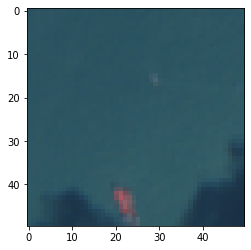

In [75]:
test_ships = test.loc[test.isShip == True]
i = 90
test_w = rio.windows.Window(test_ships.iloc[i].x,test_ships.iloc[i].y, test_ships.iloc[i].patch_size, test_ships.iloc[i].patch_size)
test_patch = sat_img.read(window=test_w)
show(test_patch)

In [70]:
training_ship_patches = create_ship_patches(ship_points, sat_img)

100% (425 of 425) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


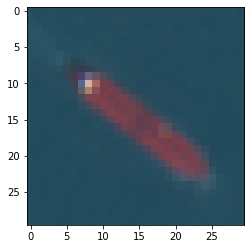

In [72]:
#plot ship patch
plt.imshow(training_ship_patches[10])

In [10]:
test_patches = create_patches(sat_img)

Creating ~133956 patches


100% (133956 of 133956) |################| Elapsed Time: 0:00:52 Time:  0:00:52


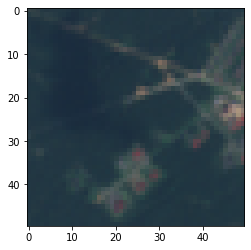

In [12]:
plt.imshow(test_patches[5567])